In [39]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#!pip install pytorch-lightning

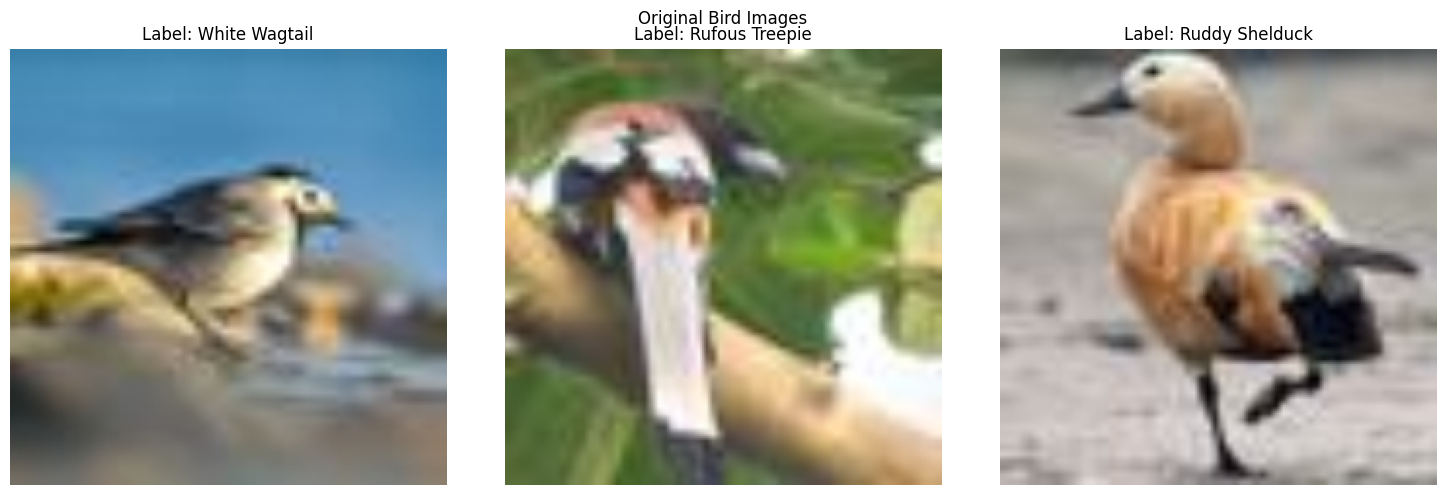

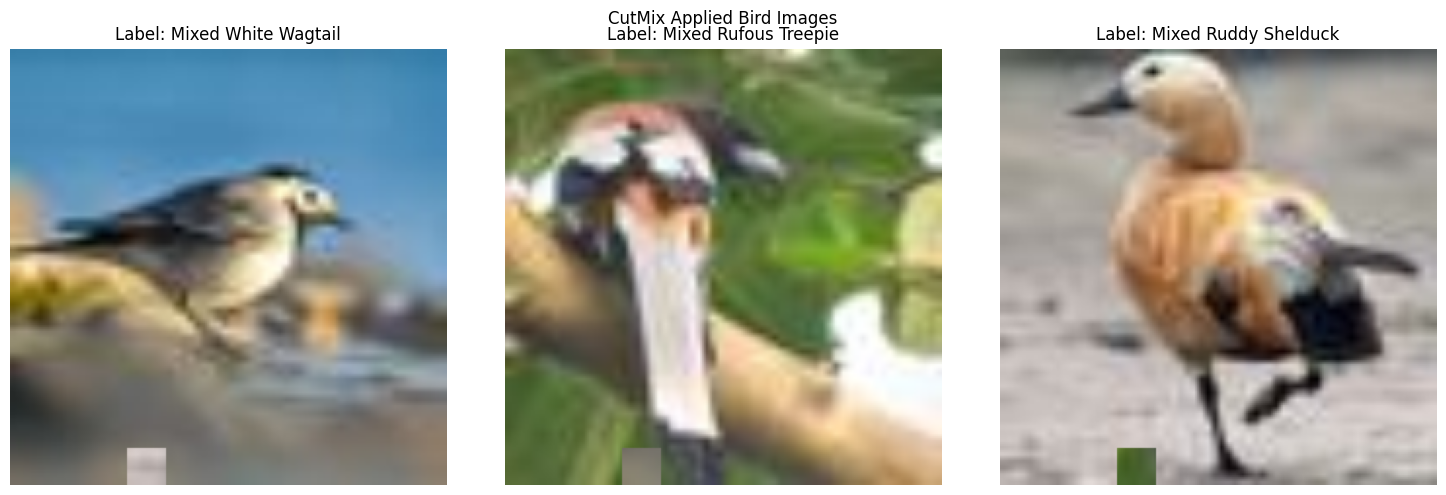


Mixed Labels Probabilities:
Image 1 mixing ratios: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00757334 0.         0.         0.99242663 0.
 0.        ]
Image 2 mixing ratios: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.99242663 0.         0.00757334 0.
 0.        ]
Image 3 mixing ratios: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.99242663 0.00757334 0.         0.         0.
 0.        ]


In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.transforms import v2
import os

# 데이터 경로 설정
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Bird/data/data"
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

# 레이블 인코딩
label_unique = {k:v for k,v in zip(sorted(train_df['label'].unique()), range(len(train_df['label'].unique())))}
train_df['label_encoded'] = train_df['label'].map(label_unique)

# 이미지 경로 수정
train_df["img_path"] = train_df["img_path"].apply(
    lambda x: os.path.join(DATA_PATH, 'train', os.path.basename(x))
)

def load_and_preprocess_images(image_paths, size=(224, 224)):
    """이미지 로드 및 전처리"""
    images = []
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        images.append(img)

    return torch.stack(images)

def show_images_grid(images, labels, title=""):
    """이미지 그리드 시각화"""
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(title)

    for idx, (img, label) in enumerate(zip(images, labels)):
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Label: {label}')

    plt.tight_layout()
    plt.show()

def apply_cutmix_to_birds(num_samples=3):
    """조류 데이터셋에 CutMix 적용 및 시각화"""
    # 랜덤하게 이미지 선택
    selected_samples = train_df.sample(n=num_samples)

    # 이미지 로드
    images = load_and_preprocess_images(selected_samples['img_path'].values)
    labels = torch.tensor(selected_samples['label_encoded'].values)

    # 원본 이미지 출력
    show_images_grid(images, selected_samples['label'].values, "Original Bird Images")

    # CutMix 적용
    num_classes = len(label_unique)
    cutmix = v2.CutMix(num_classes=num_classes)
    mixed_images, mixed_labels = cutmix(images, labels)

    # CutMix 적용된 이미지 출력
    # 레이블 디코딩을 위한 역매핑
    label_decoder = {v: k for k, v in label_unique.items()}
    mixed_labels_decoded = [
        f"Mixed {label_decoder[mixed_labels[i].argmax().item()]}"
        for i in range(len(mixed_labels))
    ]

    show_images_grid(mixed_images, mixed_labels_decoded, "CutMix Applied Bird Images")

    # 혼합 비율 출력
    print("\nMixed Labels Probabilities:")
    for idx, label_probs in enumerate(mixed_labels):
        print(f"Image {idx + 1} mixing ratios:", label_probs.numpy())

# CutMix 실행 및 시각화
apply_cutmix_to_birds(num_samples=3)

In [43]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from transformers import AutoImageProcessor, AutoModel
import cv2
from sklearn.model_selection import StratifiedKFold
from PIL import Image

class EnhancedBirdDataset(Dataset):
    def __init__(self, img_path_list, label_list, load_img_size, transforms=None,
                 cache_dir='img_cache', interpolation='robidouxsharp'):
        self.df = pd.DataFrame({'img_path': img_path_list})
        if label_list is not None:
            self.df['label'] = label_list
        self.transforms = transforms
        self.load_img_size = load_img_size
        self.cache_dir = cache_dir
        self.interpolation = interpolation
        os.makedirs(cache_dir, exist_ok=True)

    def get_cached_image(self, img_path):
        cache_path = os.path.join(
            self.cache_dir,
            f"{self.load_img_size}_{self.interpolation}_{os.path.basename(img_path)}"
        )
        if os.path.exists(cache_path):
            return Image.open(cache_path).convert('RGB')
        else:
            img = self.load_and_preprocess_image(img_path)
            img.save(cache_path)
            return img

    def load_and_preprocess_image(self, img_path):
        img = Image.open(img_path).convert('RGB')
        if self.interpolation == 'robidouxsharp':
            from wand.image import Image as WandImage
            with WandImage.from_array(np.array(img)) as wand_img:
                wand_img.resize(self.load_img_size, self.load_img_size,
                              filter=self.interpolation)
                img = Image.fromarray(np.array(wand_img))
        else:
            img = img.resize((self.load_img_size, self.load_img_size),
                           Image.LANCZOS)
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = self.get_cached_image(row['img_path'])

        if self.transforms:
            image = self.transforms(image)

        if 'label' in self.df.columns:
            label = torch.tensor(row['label'])
            return {'pixel_values': image, 'label': label}
        return {'pixel_values': image}

    def __len__(self):
        return len(self.df)

class EnhancedBirdClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.model(pixel_values)
        logits = self.classifier(outputs.pooler_output)
        return logits

class EMAModel:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = self.decay * self.shadow[name] + \
                            (1.0 - self.decay) * param.data
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

def train_fold(model, train_loader, val_loader, optimizer, scheduler,
               device, num_epochs, ema_decay=0.999):
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    ema = EMAModel(model, decay=ema_decay)

    best_val_score = 0
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(batch['pixel_values'].to(device))
                loss = criterion(outputs, batch['label'].to(device))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ema.update()
            scheduler.step()

        # Validation with EMA
        ema.apply_shadow()
        val_score = validate(model, val_loader, device)
        ema.restore()

        if val_score > best_val_score:
            best_val_score = val_score
            torch.save({
                'model_state_dict': model.state_dict(),
                'ema_shadow': ema.shadow,
                'val_score': val_score
            }, f'best_model_fold_{fold}.pt')

    return best_val_score

def get_transforms(img_size, train=True):
    if train:
        return v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            v2.TrivialAugmentWide(),
            v2.RandomErasing(),
            v2.Resize((img_size, img_size)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
    return v2.Compose([
        v2.Resize((img_size, img_size)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

def weighted_ensemble_predict(models, weights, test_loader, device):
    predictions = []
    with torch.no_grad():
        for model, weight in zip(models, weights):
            model_preds = []
            for batch in test_loader:
                outputs = model(batch['pixel_values'].to(device))
                preds = torch.softmax(outputs, dim=1)
                model_preds.append(preds.cpu().numpy())
            predictions.append(np.concatenate(model_preds) * weight)

    return np.sum(predictions, axis=0)

In [51]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from transformers import AutoImageProcessor, AutoModel
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import logging
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('training.log')
    ]
)
logger = logging.getLogger(__name__)

# Configuration
CONFIG = {
    'SEED': 42,
    'NUM_EPOCHS': 30,
    'BATCH_SIZE': 32,
    'IMG_SIZE': 224,
    'NUM_FOLDS': 5,
    'LEARNING_RATE': 1e-4,
    'MIN_LR': 1e-6,
    'WEIGHT_DECAY': 0.01,
    'MODEL_NAME': 'microsoft/beit-base-patch16-224-pt22k-ft22k',
    'CACHE_DIR': os.path.join('/content/drive/MyDrive/Colab Notebooks/Bird/data/data', 'img_cache'),
    'CHECKPOINT_DIR': os.path.join('/content/drive/MyDrive/Colab Notebooks/Bird/data/data', 'checkpoints'),
    'EMA_DECAY': 0.999,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'DATA_PATH': '/content/drive/MyDrive/Colab Notebooks/Bird/data/data',
    'INTERPOLATION': 'bicubic'
}

class EnhancedBirdDataset(Dataset):
    def __init__(self, img_path_list, label_list, load_img_size, transforms=None,
                 cache_dir='img_cache', interpolation='bicubic'):
        self.df = pd.DataFrame({'img_path': img_path_list})
        if label_list is not None:
            self.df['label'] = label_list
        self.transforms = transforms
        self.load_img_size = load_img_size
        self.cache_dir = cache_dir
        self.interpolation = interpolation
        os.makedirs(cache_dir, exist_ok=True)

    def get_cached_image(self, img_path):
        cache_path = os.path.join(
            self.cache_dir,
            f"{self.load_img_size}_{self.interpolation}_{os.path.basename(img_path)}"
        )
        if os.path.exists(cache_path):
            return Image.open(cache_path).convert('RGB')
        else:
            img = self.load_and_preprocess_image(img_path)
            img.save(cache_path)
            return img

    def load_and_preprocess_image(self, img_path):
        img = Image.open(img_path).convert('RGB')
        if self.interpolation == 'bicubic':
            resample = Image.BICUBIC
        elif self.interpolation == 'lanczos':
            resample = Image.LANCZOS
        else:
            resample = Image.BILINEAR
        img = img.resize((self.load_img_size, self.load_img_size), resample=resample)
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = self.get_cached_image(row['img_path'])

        if self.transforms:
            image = self.transforms(image)

        if 'label' in self.df.columns:
            label = torch.tensor(row['label'])
            return {'pixel_values': image, 'label': label}
        return {'pixel_values': image}

    def __len__(self):
        return len(self.df)

class MetricsLogger:
    def __init__(self, log_dir):
        self.writer = SummaryWriter(log_dir)
        self.step = 0
        self.logger = logger

    def log_metrics(self, metrics, step=None):
        if step is None:
            step = self.step
            self.step += 1
        for name, value in metrics.items():
            self.writer.add_scalar(name, value, step)
            self.logger.info(f"{name}: {value:.4f}")

    def info(self, message):
        self.logger.info(message)

    def close(self):
        self.writer.close()

class EMAModel:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = self.decay * self.shadow[name] + (1.0 - self.decay) * param.data
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

class EnhancedBirdClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.model(pixel_values)
        logits = self.classifier(outputs.pooler_output)
        return logits

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_transforms(img_size, train=True):
    if train:
        return v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.RandomVerticalFlip(),
            v2.TrivialAugmentWide(interpolation=v2.InterpolationMode.BICUBIC),
            v2.RandomErasing(p=0.3),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return v2.Compose([
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in val_loader:
            outputs = model(batch['pixel_values'].to(device))
            loss = criterion(outputs, batch['label'].to(device))
            val_loss += loss.item()

            predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(batch['label'].cpu().numpy())

    val_loss /= len(val_loader)
    val_score = f1_score(targets, predictions, average='macro')
    return val_score, val_loss

def train_fold(model, train_loader, val_loader, optimizer, scheduler,
               device, num_epochs, fold, metrics_logger, ema_decay=0.999):
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    ema = EMAModel(model, decay=ema_decay)
    best_val_score = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(batch['pixel_values'].to(device))
                loss = criterion(outputs, batch['label'].to(device))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ema.update()
            scheduler.step()

            train_losses.append(loss.item())

            if i % 100 == 0:
                metrics_logger.log_metrics({
                    f'fold_{fold}/train_loss': loss.item(),
                    f'fold_{fold}/learning_rate': optimizer.param_groups[0]['lr']
                })

        # Validation
        ema.apply_shadow()
        val_score, val_loss = validate(model, val_loader, criterion, device)
        ema.restore()

        metrics_logger.log_metrics({
            f'fold_{fold}/val_score': val_score,
            f'fold_{fold}/val_loss': val_loss,
            f'fold_{fold}/epoch_train_loss': np.mean(train_losses)
        }, epoch)

        if val_score > best_val_score:
            best_val_score = val_score
            model_path = os.path.join(
                CONFIG['CHECKPOINT_DIR'],
                f'fold_{fold}_best_model.pth'
            )
            torch.save({
                'model_state_dict': model.state_dict(),
                'ema_shadow': ema.shadow,
                'val_score': val_score,
                'epoch': epoch
            }, model_path)

            metrics_logger.info(f'Fold {fold}, Epoch {epoch}: New best model saved with validation score {val_score:.4f}')

    return best_val_score

def train_and_evaluate():
    # Set up logging directory
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_dir = os.path.join(CONFIG['DATA_PATH'], 'logs', timestamp)
    os.makedirs(log_dir, exist_ok=True)
    metrics_logger = MetricsLogger(log_dir)

    # Load and preprocess data
    train_df = pd.read_csv(os.path.join(CONFIG['DATA_PATH'], 'train.csv'))
    train_df['img_path'] = train_df['img_path'].apply(
        lambda x: os.path.join(CONFIG['DATA_PATH'], x.replace('./', ''))
    )

    # Label encoding
    le = LabelEncoder()
    train_df['label_encoded'] = le.fit_transform(train_df['label'])

    # Create directories
    os.makedirs(CONFIG['CHECKPOINT_DIR'], exist_ok=True)
    os.makedirs(CONFIG['CACHE_DIR'], exist_ok=True)

    # Create folds
    skf = StratifiedKFold(
        n_splits=CONFIG['NUM_FOLDS'],
        shuffle=True,
        random_state=CONFIG['SEED']
    )

    fold_models = []
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['label_encoded'])):
        metrics_logger.info(f"Starting fold {fold + 1}/{CONFIG['NUM_FOLDS']}")

        train_dataset = EnhancedBirdDataset(
            train_df.iloc[train_idx]['img_path'].values,
            train_df.iloc[train_idx]['label_encoded'].values,
            CONFIG['IMG_SIZE'],
            transforms=get_transforms(CONFIG['IMG_SIZE'], train=True),
            cache_dir=CONFIG['CACHE_DIR']
        )

        val_dataset = EnhancedBirdDataset(
            train_df.iloc[val_idx]['img_path'].values,
            train_df.iloc[val_idx]['label_encoded'].values,
            CONFIG['IMG_SIZE'],
            transforms=get_transforms(CONFIG['IMG_SIZE'], train=False),
            cache_dir=CONFIG['CACHE_DIR']
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=CONFIG['BATCH_SIZE'],
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=CONFIG['BATCH_SIZE'],
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        model = EnhancedBirdClassifier(
            CONFIG['MODEL_NAME'],
            num_classes=len(le.classes_)
        ).to(CONFIG['DEVICE'])

        optimizer = AdamW(
            model.parameters(),
            lr=CONFIG['LEARNING_RATE'],
            weight_decay=CONFIG['WEIGHT_DECAY']
        )

        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=len(train_loader) * 2,
            T_mult=2,
            eta_min=CONFIG['MIN_LR']
        )

        val_score = train_fold(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            device=CONFIG['DEVICE'],
            num_epochs=CONFIG['NUM_EPOCHS'],
            fold=fold,
            metrics_logger=metrics_logger,
            ema_decay=CONFIG['EMA_DECAY']
        )

        fold_scores.append(val_score)
        fold_models.append(model)

        metrics_logger.info(f"Fold {fold + 1} completed. Validation score: {val_score:.4f}")

    metrics_logger.info(f"Cross-validation scores: {fold_scores}")
    metrics_logger.info(f"Mean CV score: {np.mean(fold_scores):.4f}")
    metrics_logger.close()

    return fold_models, le, fold_scores

def predict(fold_models, le, test_df):
    test_dataset = EnhancedBirdDataset(
        test_df['img_path'].values,
        None,
        CONFIG['IMG_SIZE'],
        transforms=get_transforms(CONFIG['IMG_SIZE'], train=False),
        cache_dir=CONFIG['CACHE_DIR']
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    predictions = []
    for model in fold_models:
        model.eval()
        fold_preds = []
        with torch.no_grad():
            for batch in test_loader:
                outputs = model(batch['pixel_values'].to(CONFIG['DEVICE']))
                fold_preds.extend(outputs.argmax(dim=1).cpu().numpy())

In [52]:
# 필요한 디렉토리 생성
import os
base_path = '/content/drive/MyDrive/Colab Notebooks/Bird/data/data'
os.makedirs(os.path.join(base_path, 'img_cache'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'logs'), exist_ok=True)

In [53]:
# 데이터 경로 설정 및 확인
import os
import pandas as pd

# 기본 경로 설정
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Bird/data/data'
TRAIN_IMG_PATH = os.path.join(BASE_PATH, 'train')
TEST_IMG_PATH = os.path.join(BASE_PATH, 'test')

# CSV 파일 로드
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# 이미지 경로 수정
train_df['img_path'] = train_df['img_path'].apply(
    lambda x: os.path.join(TRAIN_IMG_PATH, os.path.basename(x))
)
test_df['img_path'] = test_df['img_path'].apply(
    lambda x: os.path.join(TEST_IMG_PATH, os.path.basename(x))
)

# 경로 확인
print("Sample paths:")
print("Train image path:", train_df['img_path'].iloc[0])
print("Path exists:", os.path.exists(train_df['img_path'].iloc[0]))

# 이미지 파일 확인
train_images = os.listdir(TRAIN_IMG_PATH)
test_images = os.listdir(TEST_IMG_PATH)
print(f"\nNumber of images found:")
print(f"Train images: {len(train_images)}")
print(f"Test images: {len(test_images)}")

# Configuration 업데이트
CONFIG.update({
    'TRAIN_IMG_PATH': TRAIN_IMG_PATH,
    'TEST_IMG_PATH': TEST_IMG_PATH,
    'DATA_PATH': BASE_PATH
})

# 데이터셋과 레이블 매칭 확인
sample_idx = 0
sample_row = train_df.iloc[sample_idx]
print(f"\nSample check:")
print(f"Image path: {sample_row['img_path']}")
print(f"Label: {sample_row['label']}")
print(f"File exists: {os.path.exists(sample_row['img_path'])}")

# 이미지 로드 테스트
from PIL import Image
try:
    test_image = Image.open(sample_row['img_path'])
    print(f"Image size: {test_image.size}")
    print("Image loading successful!")
except Exception as e:
    print(f"Error loading image: {e}")

Sample paths:
Train image path: /content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/TRAIN_00000.jpg
Path exists: True

Number of images found:
Train images: 15834
Test images: 6786

Sample check:
Image path: /content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/TRAIN_00000.jpg
Label: Ruddy Shelduck
File exists: True
Image size: (64, 64)
Image loading successful!


In [ ]:
if __name__ == "__main__":
    # 시드 설정
    set_seed(CONFIG['SEED'])

    # GPU 확인
    print(f"Using device: {CONFIG['DEVICE']}")
    print(f"GPU available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU device name: {torch.cuda.get_device_name(0)}")

    try:
        # 학습 실행
        logger.info("Starting training process...")
        fold_models, label_encoder, fold_scores = train_and_evaluate()

        # 결과 출력
        logger.info("\nTraining completed!")
        logger.info(f"Fold scores: {fold_scores}")
        logger.info(f"Mean CV score: {np.mean(fold_scores):.4f}")

        # 테스트 데이터 예측
        logger.info("\nStarting prediction on test data...")
        predictions = predict(fold_models, label_encoder, test_df)

        # 제출 파일 생성
        submission_df = pd.DataFrame({
            'id': range(len(predictions)),
            'label': predictions
        })

        # 결과 저장
        submission_path = os.path.join(CONFIG['DATA_PATH'],
                                     f'submission_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
        submission_df.to_csv(submission_path, index=False)
        logger.info(f"Predictions saved to {submission_path}")

    except KeyboardInterrupt:
        logger.info("Training interrupted by user!")
        # 현재 상태 저장
        save_path = os.path.join(CONFIG['CHECKPOINT_DIR'], 'interrupted_state.pth')
        if 'fold_models' in locals():
            torch.save({
                'fold_models': [model.state_dict() for model in fold_models],
                'fold_scores': fold_scores if 'fold_scores' in locals() else [],
                'label_encoder': label_encoder if 'label_encoder' in locals() else None,
                'config': CONFIG
            }, save_path)
            logger.info(f"Interrupted state saved to {save_path}")

    except Exception as e:
        logger.exception(f"An error occurred: {str(e)}")

    finally:
        # 메모리 정리
        torch.cuda.empty_cache()

Using device: cuda
GPU available: True
GPU device name: NVIDIA A100-SXM4-40GB


3rd 솔루션 그냥 적용 내용

In [50]:
# # 1. 필요한 라이브러리 임포트
# import os
# import torch
# import numpy as np
# import pandas as pd
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import v2
# from transformers import AutoImageProcessor, AutoModel
# import cv2
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from PIL import Image
# import logging
# from datetime import datetime
# from torch.utils.tensorboard import SummaryWriter
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# # 2. 로깅 설정
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[
#         logging.StreamHandler(),
#         logging.FileHandler('training.log')
#     ]
# )
# logger = logging.getLogger(__name__)

# # 3. Configuration 설정
# CONFIG = {
#     'SEED': 42,
#     'NUM_EPOCHS': 30,
#     'BATCH_SIZE': 32,
#     'IMG_SIZE': 224,
#     'NUM_FOLDS': 5,
#     'LEARNING_RATE': 1e-4,
#     'MIN_LR': 1e-6,
#     'WEIGHT_DECAY': 0.01,
#     'MODEL_NAME': 'microsoft/beit-base-patch16-224-pt22k-ft22k',
#     'CACHE_DIR': os.path.join('/content/drive/MyDrive/Colab Notebooks/Bird/data/data', 'img_cache'),
#     'CHECKPOINT_DIR': os.path.join('/content/drive/MyDrive/Colab Notebooks/Bird/data/data', 'checkpoints'),
#     'EMA_DECAY': 0.999,
#     'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
#     'DATA_PATH': '/content/drive/MyDrive/Colab Notebooks/Bird/data/data',
#     'INTERPOLATION': 'bicubic'
# }

# # 4. Dataset 클래스 정의
# class EnhancedBirdDataset(Dataset):
#     # (앞서 제공한 Dataset 코드)
#     ...

# # 5. MetricsLogger 클래스 정의
# class MetricsLogger:
#     # (앞서 제공한 MetricsLogger 코드)
#     ...

# # 6. EMA 모델 클래스 정의
# class EMAModel:
#     def __init__(self, model, decay=0.999):
#         self.model = model
#         self.decay = decay
#         self.shadow = {}
#         self.backup = {}
#         self.register()

#     def register(self):
#         for name, param in self.model.named_parameters():
#             if param.requires_grad:
#                 self.shadow[name] = param.data.clone()

#     def update(self):
#         for name, param in self.model.named_parameters():
#             if param.requires_grad:
#                 new_average = self.decay * self.shadow[name] + (1.0 - self.decay) * param.data
#                 self.shadow[name] = new_average.clone()

#     def apply_shadow(self):
#         for name, param in self.model.named_parameters():
#             if param.requires_grad:
#                 self.backup[name] = param.data
#                 param.data = self.shadow[name]

#     def restore(self):
#         for name, param in self.model.named_parameters():
#             if param.requires_grad:
#                 param.data = self.backup[name]

# # 7. 모델 클래스 정의
# class EnhancedBirdClassifier(nn.Module):
#     def __init__(self, model_name, num_classes):
#         super().__init__()
#         self.model = AutoModel.from_pretrained(model_name)
#         self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

#     def forward(self, pixel_values):
#         outputs = self.model(pixel_values)
#         logits = self.classifier(outputs.pooler_output)
#         return logits

# # 8. 유틸리티 함수들 정의
# def set_seed(seed=42):
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# def get_transforms(img_size, train=True):
#     # (앞서 제공한 transforms 코드)
#     ...

# # 9. 훈련 함수들 정의
# def train_fold(model, train_loader, val_loader, optimizer, scheduler,
#                device, num_epochs, fold, metrics_logger, ema_decay=0.999):
#     # (앞서 제공한 train_fold 코드)
#     ...

# def validate(model, val_loader, criterion, device):
#     # 검증 함수 구현
#     ...

# def train_and_evaluate():
#     # (앞서 제공한 train_and_evaluate 코드)
#     ...

# def predict(fold_models, le, test_df):
#     # (앞서 제공한 predict 코드)
#     ...

# # 10. 메인 실행 코드
# if __name__ == "__main__":
#     set_seed(CONFIG['SEED'])

#     try:
#         from google.colab import drive
#         drive.mount('/content/drive')
#     except ImportError:
#         pass

#     fold_models, label_encoder, fold_scores = train_and_evaluate()
#     test_df = pd.read_csv(os.path.join(CONFIG['DATA_PATH'], 'test.csv'))
#     predict(fold_models, label_encoder, test_df)

In [20]:
# # 필요한 라이브러리 임포트
# import os
# import random
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score
# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl
# from torchvision.transforms import v2
# import cv2
# from transformers import AutoImageProcessor, AutoModel
# from torch.utils.data import default_collate
# from argparse import ArgumentParser
# import warnings
# warnings.filterwarnings('ignore')

# # 설정
# parser = ArgumentParser(description="lowreso_imgclf")
# parser.add_argument('--image_pretrained_model', default="beit-base-patch16-224-pt22k-ft22k", type=str)
# parser.add_argument('--image_size', default=224, type=int)
# parser.add_argument('--aug_p', default=1, type=float)
# parser.add_argument('--optimizer', default="adamw", type=str)
# parser.add_argument('--learning_rate', default=0.00003, type=float)
# parser.add_argument('--scheduler', default="cosine", type=str)
# parser.add_argument('--batch_size', default=32, type=int)
# parser.add_argument('--epochs', default=1, type=int)
# parser.add_argument('--cv', default=5, type=int)
# parser.add_argument('--seed', default=826, type=int)
# parser.add_argument('--mixed_precision', default=16, type=int)
# parser.add_argument('--device', default=1, type=int)
# parser.add_argument('--num_workers', default=0, type=int)
# args = parser.parse_args('')

# # 시드 설정
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# def set_seeds(seed=args.seed):
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     pl.seed_everything(seed)

# set_seeds()

INFO:lightning_fabric.utilities.seed:Seed set to 826


In [21]:
# # 모델 설정
# img_model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
# latent_dim = 768
# processor = AutoImageProcessor.from_pretrained(img_model_name)

# # 데이터 로드
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test.csv')

# # 경로 설정
# train_df["img_path"] = train_df["img_path"].str.replace('./train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/')
# test_df["img_path"] = test_df["img_path"].str.replace('./test/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test/')
# train_df["upscale_img_path"] = train_df["upscale_img_path"].str.replace('./upscale_train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/upscale_train/')

# # 레이블 인코딩
# train_labels = train_df["label"]
# label_unique = {k:v for k,v in zip(sorted(np.unique(train_labels)), range(len(np.unique(train_labels))))}
# train_df["label"] = train_df["label"].apply(lambda x : label_unique[x])

# # CutMix 초기화
# cutmix = v2.CutMix(num_classes=len(label_unique))

In [22]:
# # Dataset 클래스
# class ImageDataset(Dataset):
#     def __init__(self, df, img_path, is_test=False, transform=None):
#         self.df = df
#         self.processor = processor
#         self.img_path = img_path
#         self.is_test = is_test
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         image = cv2.imread(row[self.img_path])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if not self.is_test:
#             encoding = self.processor(images=image, return_tensors="pt")
#             encoding["labels"] = torch.tensor(row['label'], dtype=torch.long)
#             for k,v in encoding.items():
#                 if hasattr(v, 'squeeze'):
#                     encoding[k] = v.squeeze()
#             return encoding

#         encoding = self.processor(images=image, return_tensors="pt")
#         for k,v in encoding.items():
#             if hasattr(v, 'squeeze'):
#                 encoding[k] = v.squeeze()
#         return encoding

# # 모델 클래스들
# class ImageModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = AutoModel.from_pretrained(img_model_name)
#         self.clf = nn.Linear(latent_dim, len(label_unique))

#     def forward(self, inputs):
#         enc = self.model(inputs)
#         x = enc.pooler_output
#         outputs = self.clf(x)
#         return outputs

# class ImageClassifier(pl.LightningModule):
#     def __init__(self, backbone, args):
#         super().__init__()
#         self.backbone = backbone

#     def forward(self, x):
#         return self.backbone(x)

#     def step(self, batch):
#         x = batch["pixel_values"]
#         y = batch["labels"]
#         y_hat = self.forward(x)
#         loss = nn.CrossEntropyLoss()(y_hat, y)
#         return loss, y, y_hat

#     def training_step(self, batch, batch_idx):
#         loss_ce, y, y_hat = self.step(batch)
#         loss_cos = nn.CosineEmbeddingLoss()(
#             y_hat, y, torch.Tensor([1]).to(self.device)
#         )
#         loss = loss_ce + loss_cos
#         print(f"Batch {batch_idx}, Loss: {loss.item()}")
#         f1 = f1_score(y_hat.max(dim=1)[1].cpu().numpy(), y.max(dim=1)[1].cpu().numpy(), average='macro')
#         self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         loss_ce, y, y_hat = self.step(batch)
#         loss_cos = nn.CosineEmbeddingLoss()(
#             y_hat, F.one_hot(y.long(), len(label_unique)), torch.Tensor([1]).to(self.device)
#         )
#         loss = loss_ce + loss_cos
#         f1 = f1_score(y_hat.max(dim=1)[1].cpu().numpy(), y.cpu().numpy(), average='macro')
#         self.log('val_loss', loss, on_epoch=True, prog_bar=True)
#         self.log("val_f1", f1, on_epoch=True, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.parameters(), lr=args.learning_rate)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#             optimizer=optimizer,
#             T_max=max(args.epochs//2, 1),
#             eta_min=args.learning_rate//10,
#         )
#         return [optimizer], [scheduler]

# def collate_fn(batch):
#     data = default_collate(batch)
#     data = cutmix(data['pixel_values'], data['labels'])
#     return {'pixel_values': data[0], 'labels': data[1]}

In [23]:
# # 학습 준비
# val_f1_list = []
# skf = StratifiedKFold(n_splits=args.cv, shuffle=True, random_state=args.seed)

# # 학습 수행
# for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df["label"])):
#     temp_df = train_df.iloc[train_index]
#     val_df = train_df.iloc[val_index]

#     # 데이터셋 생성
#     train_ds_low = ImageDataset(temp_df, "img_path", is_test=False)
#     train_ds_high = ImageDataset(temp_df, "upscale_img_path", is_test=False)
#     train_ds = train_ds_low + train_ds_high
#     val_ds = ImageDataset(val_df, "img_path", is_test=False)

#     # 데이터로더 설정
#     train_dataloader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,
#                                   num_workers=args.num_workers, collate_fn=collate_fn)
#     val_dataloader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False,
#                                 num_workers=args.num_workers)

#     # 모델 및 트레이너 설정
#     model = ImageClassifier(ImageModel(), args)
#     callbacks = [pl.callbacks.ModelCheckpoint(
#         dirpath="saved/",
#         filename=f"beit-base-patch16-224-pt22k-ft22k_{i}",
#         monitor="val_f1",
#         mode="max"
#     )]

#     trainer = pl.Trainer(
#         max_epochs=args.epochs,
#         accelerator="auto",
#         callbacks=[*callbacks, pl.callbacks.TQDMProgressBar(refresh_rate=1)],
#         precision=args.mixed_precision,
#         devices=args.device
#     )

#     # 학습
#     trainer.fit(model, train_dataloader, val_dataloader)

#     # 체크포인트 로드
#     ckpt = torch.load(f"saved/beit-base-patch16-224-pt22k-ft22k_{i}.ckpt", map_location=device)
#     model.load_state_dict(ckpt['state_dict'])

#     # 검증 결과 저장
#     eval_dict = trainer.validate(model, dataloaders=val_dataloader)[0]
#     val_f1_list.append(eval_dict["val_f1"])

# # 검증 F1 평균 출력
# val_f1_mean = np.mean(val_f1_list)
# print(f"Validation F1 Mean: {val_f1_mean}")


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | backbone | ImageModel | 85.8 M | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Batch 0, Loss: 4.329592704772949
Batch 1, Loss: 4.052292346954346
Batch 2, Loss: 4.203272819519043
Batch 3, Loss: 4.138926982879639
Batch 4, Loss: 4.01518440246582
Batch 5, Loss: 4.089448928833008
Batch 6, Loss: 4.047309875488281
Batch 7, Loss: 4.097050189971924
Batch 8, Loss: 4.069786071777344
Batch 9, Loss: 4.300349235534668
Batch 10, Loss: 3.748945951461792
Batch 11, Loss: 3.5598936080932617
Batch 12, Loss: 4.0409722328186035
Batch 13, Loss: 3.755070209503174
Batch 14, Loss: 3.78810977935791
Batch 15, Loss: 3.748483180999756
Batch 16, Loss: 3.713646650314331
Batch 17, Loss: 3.6703433990478516
Batch 18, Loss: 3.395648241043091
Batch 19, Loss: 3.6953468322753906
Batch 20, Loss: 3.6006968021392822
Batch 21, Loss: 3.7484707832336426


INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# import torch
# import pytorch_lightning as pl
# import numpy as np
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from transformers import BeitFeatureExtractor, BeitForImageClassification
# from PIL import Image

# class ImageDataset(Dataset):
#     def __init__(self, df, img_path_col, is_test=False):
#         self.df = df
#         self.img_path_col = img_path_col
#         self.is_test = is_test
#         self.feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_path = self.df.iloc[idx][self.img_path_col]
#         image = Image.open(img_path).convert('RGB')

#         # Apply feature extraction
#         features = self.feature_extractor(images=image, return_tensors="pt")
#         pixel_values = features['pixel_values'].squeeze()

#         if self.is_test:
#             return pixel_values
#         else:
#             label = self.df.iloc[idx]['label']
#             return pixel_values, label

# class ImageClassifier(pl.LightningModule):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.model = BeitForImageClassification.from_pretrained(
#             'microsoft/beit-base-patch16-224-pt22k-ft22k',
#             num_labels=num_classes,
#             ignore_mismatched_sizes=True
#         )

#     def forward(self, pixel_values):
#         outputs = self.model(pixel_values=pixel_values)
#         return outputs.logits

#     def predict_step(self, batch, batch_idx):
#         pixel_values = batch
#         logits = self(pixel_values)
#         return torch.softmax(logits, dim=1)

# def predict_images(test_df, args, label_unique, device):
#     preds_list = []

#     # 테스트 데이터셋 생성
#     test_ds = ImageDataset(test_df, "img_path", is_test=True)
#     test_dataloader = DataLoader(
#         test_ds,
#         batch_size=args.batch_size,
#         shuffle=False,
#         num_workers=args.num_workers
#     )

#     # Cross validation 예측 수행
#     for i in range(args.cv):
#         # 모델 생성 및 체크포인트 로드
#         model = ImageClassifier(num_classes=len(label_unique))
#         ckpt = torch.load(
#             f"saved/beit-base-patch16-224-pt22k-ft22k_{i}.ckpt",
#             map_location=device
#         )
#         model.load_state_dict(ckpt['state_dict'])
#         model = model.to(device)
#         model.eval()

#         # 예측
#         trainer = pl.Trainer(
#             accelerator="auto",
#             precision=args.mixed_precision,
#             devices=args.device
#         )
#         y_preds = trainer.predict(model, dataloaders=test_dataloader)
#         preds_list.append(np.vstack(y_preds))

#     # 예측 결과 집계
#     y_pred = np.mean(preds_list, axis=0)
#     preds = y_pred.argmax(axis=1)

#     # 레이블 디코딩 및 결과 저장
#     label_decoder = {val: key for key, val in label_unique.items()}
#     result = [label_decoder[pred] for pred in preds]

#     submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/sample_submission.csv')
#     submit["label"] = result
#     submit.to_csv('beit-base-patch16-224-pt22k-ft22k.csv', index=False)

#     return submit

결과출력

In [34]:
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# import numpy as np
# import pandas as pd
# import cv2
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoModel, AutoProcessor
# from sklearn.metrics import f1_score
# import torch.nn.functional as F
# from torch.utils.data.dataloader import default_collate

# # 데이터 로드
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test.csv')
# test_df["img_path"] = test_df["img_path"].apply(lambda x: os.path.join('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test', x))


# # 레이블 인코딩
# train_labels = train_df["label"]
# label_unique = {k:v for k,v in zip(sorted(np.unique(train_labels)), range(len(np.unique(train_labels))))}

# # 모델 설정
# img_model_name = "microsoft/swinv2-large-patch4-window12-192-22k"
# latent_dim = 1536
# processor = AutoProcessor.from_pretrained(img_model_name)

# # Dataset 클래스
# class ImageDataset(Dataset):
#     def __init__(self, df, img_path, is_test=False, transform=None):
#         self.df = df
#         self.processor = processor
#         self.img_path = img_path
#         self.is_test = is_test
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         image = cv2.imread(row[self.img_path])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if not self.is_test:
#             encoding = self.processor(images=image, return_tensors="pt")
#             encoding["labels"] = torch.tensor(row['label'], dtype=torch.long)
#             for k,v in encoding.items():
#                 if hasattr(v, 'squeeze'):
#                     encoding[k] = v.squeeze()
#             return encoding

#         encoding = self.processor(images=image, return_tensors="pt")
#         for k,v in encoding.items():
#             if hasattr(v, 'squeeze'):
#                 encoding[k] = v.squeeze()
#         return encoding

# # 모델 클래스들
# class ImageModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = AutoModel.from_pretrained(img_model_name)
#         # 인덱스를 1로 설정
#         self.clf = nn.Sequential(
#             nn.Identity(),  # 0번 인덱스
#             nn.Linear(latent_dim, len(label_unique))  # 1번 인덱스
#         )

#     def forward(self, inputs):
#         enc = self.model(inputs)
#         x = enc.pooler_output
#         outputs = self.clf(x)
#         return outputs

# class ImageClassifier(pl.LightningModule):
#     def __init__(self, backbone, args):
#         super().__init__()
#         self.model = backbone

#     def forward(self, x):
#         return self.model(x)

#     def predict_step(self, batch, batch_idx):
#         x = batch["pixel_values"]
#         y_hat = self.forward(x)
#         return torch.softmax(y_hat, dim=1)
# # 매개변수 설정
# class Args:
#     batch_size = 32
#     num_workers = 4
#     cv = 1
#     mixed_precision = '16-mixed'
#     device = 1
#     learning_rate = 1e-5
#     epochs = 10

# args = Args()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def predict_images(test_df, args, label_unique, device):
#     preds_list = []

#     # 테스트 데이터셋 생성
#     test_ds = ImageDataset(test_df, "img_path", is_test=True)
#     test_dataloader = DataLoader(
#         test_ds,
#         batch_size=args.batch_size,
#         shuffle=False,
#         num_workers=args.num_workers
#     )

#     # 체크포인트 파일 경로
#     checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Bird/data/checkpoints/swinv2-large-resize-fold_idx=0-epoch=00-train_loss=0.5881-val_score=0.9584.ckpt'

#     # 모델 생성 및 체크포인트 로드
#     model = ImageClassifier(ImageModel(), args)
#     ckpt = torch.load(checkpoint_path, map_location=device)
#     model.load_state_dict(ckpt['state_dict'])
#     model = model.to(device)
#     model.eval()

#     # 예측
#     trainer = pl.Trainer(
#         accelerator="auto",
#         precision=args.mixed_precision,
#         devices=args.device
#     )
#     y_preds = trainer.predict(model, dataloaders=test_dataloader)
#     preds_list.append(np.vstack(y_preds))

#     # 예측 결과 집계
#     y_pred = np.mean(preds_list, axis=0)
#     preds = y_pred.argmax(axis=1)

#     # 레이블 디코딩 및 결과 저장
#     label_decoder = {val: key for key, val in label_unique.items()}
#     result = [label_decoder[pred] for pred in preds]

#     submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/sample_submission.csv')
#     submit["label"] = result
#     submit.to_csv('swinv2_predictions.csv', index=False)

#     return submit

# # 예측 실행
# results = predict_images(test_df, args, label_unique, device)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-34-c8ea2dc7ece5>", line 43, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [37]:
# import os
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# import numpy as np
# import pandas as pd
# import cv2
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoModel, AutoProcessor

# # 모델 설정
# img_model_name = "microsoft/swinv2-large-patch4-window12-192-22k"
# latent_dim = 1536
# processor = AutoProcessor.from_pretrained(img_model_name)

# class ImageDataset(Dataset):
#     def __init__(self, df, img_path, is_test=False, transform=None):
#         self.df = df
#         self.processor = processor
#         self.img_path = img_path
#         self.is_test = is_test
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         try:
#             row = self.df.iloc[idx]
#             img_path = row[self.img_path]

#             if not os.path.exists(img_path):
#                 print(f"Image file not found: {img_path}")
#                 raise FileNotFoundError(f"Image file not found: {img_path}")

#             image = cv2.imread(img_path)
#             if image is None:
#                 print(f"Failed to load image: {img_path}")
#                 raise ValueError(f"Failed to load image: {img_path}")

#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             if not self.is_test:
#                 encoding = self.processor(images=image, return_tensors="pt")
#                 encoding["labels"] = torch.tensor(row['label'], dtype=torch.long)
#                 for k,v in encoding.items():
#                     if hasattr(v, 'squeeze'):
#                         encoding[k] = v.squeeze()
#                 return encoding

#             encoding = self.processor(images=image, return_tensors="pt")
#             for k,v in encoding.items():
#                 if hasattr(v, 'squeeze'):
#                     encoding[k] = v.squeeze()
#             return encoding

#         except Exception as e:
#             print(f"Error processing image at index {idx}: {str(e)}")
#             raise

# class ImageModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = AutoModel.from_pretrained(img_model_name)
#         self.clf = nn.Sequential(
#             nn.Identity(),  # 0번 인덱스
#             nn.Linear(latent_dim, len(label_unique))  # 1번 인덱스
#         )

#     def forward(self, inputs):
#         enc = self.model(inputs)
#         x = enc.pooler_output
#         outputs = self.clf(x)
#         return outputs

# class ImageClassifier(pl.LightningModule):
#     def __init__(self, backbone, args):
#         super().__init__()
#         self.model = backbone

#     def forward(self, x):
#         return self.model(x)

#     def predict_step(self, batch, batch_idx):
#         x = batch["pixel_values"]
#         y_hat = self.forward(x)
#         return torch.softmax(y_hat, dim=1)

# def predict_images(test_df, args, label_unique, device):
#     preds_list = []

#     # 테스트 데이터셋 생성
#     test_ds = ImageDataset(test_df, "img_path", is_test=True)
#     test_dataloader = DataLoader(
#         test_ds,
#         batch_size=args.batch_size,
#         shuffle=False,
#         num_workers=args.num_workers
#     )

#     # 체크포인트 파일 경로
#     checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Bird/data/checkpoints/swinv2-large-resize-fold_idx=0-epoch=00-train_loss=0.5881-val_score=0.9584.ckpt'

#     # 모델 생성 및 체크포인트 로드
#     model = ImageClassifier(ImageModel(), args)
#     ckpt = torch.load(checkpoint_path, map_location=device)
#     model.load_state_dict(ckpt['state_dict'])
#     model = model.to(device)
#     model.eval()

#     # 예측
#     trainer = pl.Trainer(
#         accelerator="auto",
#         precision=args.mixed_precision,
#         devices=args.device
#     )
#     y_preds = trainer.predict(model, dataloaders=test_dataloader)
#     preds_list.append(np.vstack(y_preds))

#     # 예측 결과 집계
#     y_pred = np.mean(preds_list, axis=0)
#     preds = y_pred.argmax(axis=1)

#     # 레이블 디코딩 및 결과 저장
#     label_decoder = {val: key for key, val in label_unique.items()}
#     result = [label_decoder[pred] for pred in preds]

#     submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/sample_submission.csv')
#     submit["label"] = result
#     submit.to_csv('swinv2_predictions.csv', index=False)

#     return submit

# # 테스트 데이터프레임 로드
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test.csv')

# # 이미지 경로 수정 (./test/ 부분을 제거하고 직접 경로 설정)
# test_df["img_path"] = test_df["img_path"].apply(lambda x: os.path.join('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test', os.path.basename(x)))

# # 첫 번째 이미지 경로 확인
# print("First image path:", test_df["img_path"].iloc[0])
# print("File exists:", os.path.exists(test_df["img_path"].iloc[0]))
# # Args 설정
# class Args:
#     batch_size = 32
#     num_workers = 4
#     cv = 1
#     mixed_precision = '16-mixed'
#     device = 1
#     learning_rate = 1e-5
#     epochs = 10

# args = Args()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 예측 실행
# results = predict_images(test_df, args, label_unique, device)

First image path: /content/drive/MyDrive/Colab Notebooks/Bird/data/data/test/TEST_00000.jpg
File exists: True


model.safetensors:   0%|          | 0.00/915M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

여기부터는 기존 코드고 위에 코드가 코랩으로 돌아가는 코드임

In [38]:
# import os
# print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /content


In [ ]:

# # Imports
# import os
# import random
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score
# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl
# from torchvision.transforms import v2
# import cv2
# from transformers import AutoImageProcessor, AutoModel
# from torch.utils.data import default_collate
# import warnings
# warnings.filterwarnings('ignore')

# # Config
# parser = ArgumentParser(description="lowreso_imgclf")
# parser.add_argument('--image_pretrained_model', default="beit-base-patch16-224-pt22k-ft22k", type=str)
# parser.add_argument('--image_size', default=224, type=int)
# parser.add_argument('--aug_p', default=1, type=float)
# parser.add_argument('--optimizer', default="adamw", type=str)
# parser.add_argument('--learning_rate', default=0.00003, type=float)
# parser.add_argument('--scheduler', default="cosine", type=str)
# parser.add_argument('--batch_size', default=64, type=int)
# parser.add_argument('--epochs', default=1, type=int)  # Changed to 1
# parser.add_argument('--cv', default=5, type=int)
# parser.add_argument('--seed', default=826, type=int)
# parser.add_argument('--mixed_precision', default=16, type=int)
# parser.add_argument('--device', default=1, type=int)  # Changed to single GPU
# parser.add_argument('--num_workers', default=0, type=int)
# args = parser.parse_args('')

# # Set device and seed
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# def set_seeds(seed=args.seed):
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     pl.seed_everything(seed)

# set_seeds()

# # Model config
# img_model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
# latent_dim = 768
# processor = AutoImageProcessor.from_pretrained(img_model_name)

# # Load and preprocess data
# train_df["img_path"] = train_df["img_path"].str.replace('./train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/')
# test_df["img_path"] = test_df["img_path"].str.replace('./test/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test/')
# train_df["upscale_img_path"] = train_df["upscale_img_path"].str.replace('./upscale_train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/upscale_train/')

# # 학습 데이터셋 구성 부분도 원래대로 복구
# train_ds_low = ImageDataset(temp_df, "img_path", is_test=False)
# train_ds_high = ImageDataset(temp_df, "upscale_img_path", is_test=False)
# train_ds = train_ds_low + train_ds_high

# # Create label mapping
# train_labels = train_df["label"]
# label_unique = {k:v for k,v in zip(sorted(np.unique(train_labels)), range(len(np.unique(train_labels))))}
# train_df["label"] = train_df["label"].apply(lambda x : label_unique[x])

# # Initialize CutMix
# cutmix = v2.CutMix(num_classes=len(label_unique))

# # Dataset class
# class ImageDataset(Dataset):
#     def __init__(self, df, img_path, is_test=False, transform=None):
#         self.df = df
#         self.processor = processor
#         self.img_path = img_path
#         self.is_test = is_test
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         image = cv2.imread(row[self.img_path])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         encoding = self.processor(images=image, return_tensors="pt")
#         pixel_values = encoding["pixel_values"]
#         print(f"Pixel values shape in Dataset: {pixel_values.shape}")  # 디버깅 출력

#         if not self.is_test:
#             encoding["labels"] = torch.tensor(row['label'], dtype=torch.long)
#         return encoding



# # Model classes
# class ImageModel(nn.Module):
#     def forward(self, inputs):
#         print(f"Model input shape: {inputs.shape}")  # 디버깅 출력

#         # 입력 차원 강제 조정
#         if len(inputs.shape) != 4:
#             inputs = inputs.squeeze(1)  # 필요시 수정
#             print(f"Adjusted input shape: {inputs.shape}")

#         enc = self.model(inputs)
#         x = enc.pooler_output
#         outputs = self.clf(x)
#         return outputs


# class ImageClassifier(pl.LightningModule):
#     def __init__(self, backbone, args):
#         super().__init__()
#         self.backbone = backbone

#     def forward(self, x):
#         return self.backbone(x)

#     def step(self, batch):
#         x = batch["pixel_values"]
#         y = batch["labels"]
#         y_hat = self.forward(x)
#         loss = nn.CrossEntropyLoss()(y_hat, y)
#         return loss, y, y_hat

#     def training_step(self, batch, batch_idx):
#         loss_ce, y, y_hat = self.step(batch)
#         loss_cos = nn.CosineEmbeddingLoss()(
#             y_hat, y, torch.Tensor([1]).to(self.device)
#         )
#         loss = loss_ce + loss_cos
#         print(f"Batch {batch_idx}, Loss: {loss.item()}")
#         f1 = f1_score(y_hat.max(dim=1)[1].cpu().numpy(), y.max(dim=1)[1].cpu().numpy(), average='macro')
#         self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         loss_ce, y, y_hat = self.step(batch)
#         loss_cos = nn.CosineEmbeddingLoss()(
#             y_hat, F.one_hot(y.long(), len(label_unique)), torch.Tensor([1]).to(self.device)
#         )
#         loss = loss_ce + loss_cos
#         f1 = f1_score(y_hat.max(dim=1)[1].cpu().numpy(), y.cpu().numpy(), average='macro')
#         self.log('val_loss', loss, on_epoch=True, prog_bar=True)
#         self.log("val_f1", f1, on_epoch=True, prog_bar=True)
#         return loss
#     def configure_optimizers(self):

#       optimizer = torch.optim.AdamW(self.parameters(), lr=args.learning_rate)
#       scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#           optimizer=optimizer,
#           T_max=max(args.epochs//2, 1),  # 최소값 1 설정
#           eta_min=args.learning_rate//10,
#       )
#       return [optimizer], [scheduler]

# # Collate function
# def collate_fn(batch):
#     data = default_collate(batch)
#     print(f"Before CutMix: {data['pixel_values'].shape}")  # 디버깅 출력
#     data = cutmix(data['pixel_values'], data['labels'])

#     # 배치 차원 강제 보장
#     if len(data[0].shape) != 4:
#         data = (data[0].squeeze(1), data[1])  # 필요시 차원 조정

#     print(f"After CutMix: {data[0].shape}")  # 디버깅 출력
#     return {'pixel_values': data[0], 'labels': data[1]}

# # Training
# val_f1_list = []
# preds_list = []

# skf = StratifiedKFold(n_splits=args.cv, shuffle=True, random_state=args.seed)
# print(torch.cuda.memory_summary())
# for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df["label"])):
#     temp_df = train_df.iloc[train_index]
#     val_df = train_df.iloc[val_index]

#     train_ds = ImageDataset(temp_df, "img_path", is_test=False)
#     val_ds = ImageDataset(val_df, "img_path", is_test=False)
#     test_ds = ImageDataset(test_df, "img_path", is_test=True)

#     train_dataloader = DataLoader(
#         train_ds, batch_size=args.batch_size, shuffle=True,
#         num_workers=args.num_workers, collate_fn=collate_fn
#     )
#     val_dataloader = DataLoader(
#         val_ds, batch_size=args.batch_size, shuffle=False,
#         num_workers=args.num_workers
#     )
#     test_dataloader = DataLoader(
#         test_ds, batch_size=args.batch_size, shuffle=False,
#         num_workers=args.num_workers
#     )

#     # 디버깅 코드: 테스트 데이터 로더에서 배치 데이터 확인
#     for batch in test_dataloader:
#         print(f"Test batch pixel_values shape: {batch['pixel_values'].shape}")
#         break


#     model = ImageClassifier(ImageModel(), args)
#     callbacks = [pl.callbacks.ModelCheckpoint(
#         dirpath="saved/",
#         filename=f"beit-base-patch16-224-pt22k-ft22k_{i}",
#         monitor="val_f1",
#         mode="max"
#     )]

#     trainer = pl.Trainer(
#         max_epochs=args.epochs,
#         accelerator="auto",
#         callbacks=[*callbacks, pl.callbacks.TQDMProgressBar(refresh_rate=1)],
#         precision=args.mixed_precision,
#         devices=args.device
#     )

#     trainer.fit(model, train_dataloader, val_dataloader)

#     # Load best checkpoint and make predictions
#     ckpt = torch.load(f"saved/beit-base-patch16-224-pt22k-ft22k_{i}.ckpt", map_location=device)
#     model.load_state_dict(ckpt['state_dict'])

#     eval_dict = trainer.validate(model, dataloaders=val_dataloader)[0]
#     val_f1_list.append(eval_dict["val_f1"])

#     # Trainer predict 호출
#     y_preds = trainer.predict(model, dataloaders=test_dataloader)
#     preds_list.append(np.vstack(y_preds))

# # Final predictions and submission
# val_f1_mean = np.mean(val_f1_list)
# print(f"Validation F1 Mean: {val_f1_mean}")

# y_pred = np.mean(preds_list, axis=0)
# preds = y_pred.argmax(axis=1)

# label_decoder = {val:key for key, val in label_unique.items()}
# result = [label_decoder[pred] for pred in preds]

# submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/sample_submission.csv')
# submit["label"] = result
# submit.to_csv('beit-base-patch16-224-pt22k-ft22k.csv', index=False)


In [ ]:
# model = ImageClassifier(ImageModel(), args)
# print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())}")


In [ ]:
# def collate_fn(batch):
#     data = default_collate(batch)
#     print(f"Before CutMix: {data['pixel_values'].shape}")
#     data = cutmix(data['pixel_values'], data['labels'])
#     print(f"After CutMix: {data[0].shape}")
#     return {'pixel_values': data[0], 'labels': data[1]}


In [ ]:
# # 기본 경로 수정
# BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/Bird/data/data"

# # 이미지 경로 수정
# train_df["img_path"] = train_df["img_path"].apply(lambda x : os.path.join(BASE_PATH, x))
# test_df["img_path"] = test_df["img_path"].apply(lambda x : os.path.join(BASE_PATH, x))
# train_df["upscale_img_path"] = train_df["upscale_img_path"].apply(lambda x : os.path.join(BASE_PATH, x))

# # 경로 확인
# print(train_df["img_path"].iloc[0])
# print(f"File exists: {os.path.exists(train_df['img_path'].iloc[0])}")

In [ ]:
# print("Training image path example:", train_df['img_path'].iloc[0])
# print("Does file exist?", os.path.exists(train_df['img_path'].iloc[0]))
# print("Dataset size:", len(train_df))

In [ ]:
# # Load CSVs
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test.csv')

# # Set correct paths
# train_df["img_path"] = train_df["img_path"].str.replace('./train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/')
# test_df["img_path"] = test_df["img_path"].str.replace('./test/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test/')
# train_df["upscale_img_path"] = train_df["upscale_img_path"].str.replace('./train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/')

# # Verify
# print("Sample train path:", train_df['img_path'].iloc[0])
# print("File exists?", os.path.exists(train_df['img_path'].iloc[0]))

In [ ]:
# # Set epoch to 1
# args.epochs = 1
# args.device = 1

# # BEiT model config
# if args.image_pretrained_model == "beit-base-patch16-224-pt22k-ft22k":
#     img_model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
#     latent_dim = 768

# processor = AutoImageProcessor.from_pretrained(img_model_name)

# # Load and preprocess data
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test.csv')

# train_df["img_path"] = train_df["img_path"].str.replace('./train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/')
# test_df["img_path"] = test_df["img_path"].str.replace('./test/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/test/')
# train_df["upscale_img_path"] = train_df["upscale_img_path"].str.replace('./train/', '/content/drive/MyDrive/Colab Notebooks/Bird/data/data/train/')
# # Create label mapping
# train_labels = train_df["label"]
# label_unique = {k:v for k,v in zip(sorted(np.unique(train_labels)), range(len(np.unique(train_labels))))}
# train_df["label"] = train_df["label"].apply(lambda x : label_unique[x])

# # Initialize CutMix
# cutmix = v2.CutMix(num_classes=len(label_unique))

# # Define dataset and model classes as in the original code
# class ImageDataset(Dataset):
#    def __init__(self, df, img_path, is_test=False, transform=None):
#        self.df = df
#        self.processor = processor
#        self.img_path = img_path
#        self.is_test = is_test
#        self.transform = transform

#    def __len__(self):
#        return len(self.df)

#    def __getitem__(self, idx):
#        row = self.df.iloc[idx]
#        print(f"Trying to load image: {row[self.img_path]}")
#        print(f"File exists: {os.path.exists(row[self.img_path])}")
#        image = cv2.imread(row[self.img_path])
#        if image is None:
#            print(f"Failed to load image at index {idx}")
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#        if not self.is_test:
#            encoding = self.processor(images=image, return_tensors="pt")
#            encoding["labels"] = torch.tensor(row['label'], dtype=torch.long)
#            for k,v in encoding.items():
#                encoding[k] = v.squeeze()
#            return encoding

#        encoding = self.processor(images=image, return_tensors="pt")
#        for k,v in encoding.items():
#            encoding[k] = v.squeeze()
#        return encoding

# class ImageModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = AutoModel.from_pretrained(img_model_name)
#         self.clf = nn.Linear(latent_dim, len(label_unique))

#     def forward(self, inputs):
#         enc = self.model(inputs)
#         x = enc.pooler_output
#         outputs = self.clf(x)
#         return outputs

# class ImageClassifier(pl.LightningModule):
#     def __init__(self, backbone, args):
#         super().__init__()
#         self.backbone = backbone

#     def forward(self, x):
#         return self.backbone(x)

#     def step(self, batch):
#         x = batch["pixel_values"]
#         y = batch["labels"]
#         y_hat = self.forward(x)
#         loss = nn.CrossEntropyLoss()(y_hat, y)
#         return loss, y, y_hat

#     def training_step(self, batch, batch_idx):
#         loss_ce, y, y_hat = self.step(batch)
#         loss_cos = nn.CosineEmbeddingLoss()(
#             y_hat, y, torch.Tensor([1]).to(self.device)
#         )
#         loss = loss_ce + loss_cos
#         self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         loss_ce, y, y_hat = self.step(batch)
#         loss_cos = nn.CosineEmbeddingLoss()(
#             y_hat, F.one_hot(y.long(), len(label_unique)), torch.Tensor([1]).to(self.device)
#         )
#         loss = loss_ce + loss_cos
#         f1 = f1_score(y_hat.max(dim=1)[1].cpu().numpy(), y.cpu().numpy(), average='macro')
#         self.log('val_loss', loss, on_epoch=True, prog_bar=True)
#         self.log("val_f1", f1, on_epoch=True, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.parameters(), lr=args.learning_rate)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#             optimizer=optimizer,
#             T_max=args.epochs//2,
#             eta_min=args.learning_rate//10,
#         )
#         return [optimizer], [scheduler]

# # Training setup and execution
# def collate_fn(batch):
#     data = default_collate(batch)
#     data = cutmix(data['pixel_values'], data['labels'])
#     return {'pixel_values': data[0], 'labels': data[1]}

# val_f1_list = []
# preds_list = []

# skf = StratifiedKFold(n_splits=args.cv, shuffle=True, random_state=args.seed)

# for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df["label"])):
#     temp_df = train_df.iloc[train_index]
#     val_df = train_df.iloc[val_index]

#     train_ds = ImageDataset(temp_df, "img_path", is_test=False) + ImageDataset(temp_df, "upscale_img_path", is_test=False)
#     val_ds = ImageDataset(val_df, "img_path", is_test=False)
#     test_ds = ImageDataset(test_df, "img_path", is_test=True)

#     train_dataloader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, collate_fn=collate_fn)
#     val_dataloader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
#     test_dataloader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

#     model = ImageClassifier(ImageModel(), args)
#     callbacks = [pl.callbacks.ModelCheckpoint(dirpath="saved/", filename=f"{args.image_pretrained_model}_{i}", monitor="val_f1", mode="max")]

#     trainer = pl.Trainer(
#         max_epochs=args.epochs,
#         accelerator="auto",
#         callbacks=callbacks,
#         precision=args.mixed_precision,
#         devices=args.device
#     )

#     trainer.fit(model, train_dataloader, val_dataloader)

#     # Load best checkpoint and make predictions
#     ckpt = torch.load(f"saved/{args.image_pretrained_model}_{i}.ckpt", map_location=device)
#     model.load_state_dict(ckpt['state_dict'])

#     eval_dict = trainer.validate(model, dataloaders=val_dataloader)[0]
#     val_f1_list.append(eval_dict["val_f1"])

#     y_preds = trainer.predict(model, dataloaders=test_dataloader)
#     preds_list.append(np.vstack(y_preds))

# # Calculate final predictions and create submission
# val_f1_mean = np.mean(val_f1_list)
# print(f"Validation F1 Mean: {val_f1_mean}")

# y_pred = np.mean(preds_list, axis=0)
# preds = y_pred.argmax(axis=1)

# label_decoder = {val:key for key, val in label_unique.items()}
# result = [label_decoder[pred] for pred in preds]

# submit = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))
# submit["label"] = result
# submit.to_csv(f'{args.image_pretrained_model}.csv', index=False)